# Spectral Analysis

We are familiar with thinking about light in terms of its color content, and sound, especially music, in terms of its frequency content.  We do the same with geophysical time series--we describe them, break them up, or filter them based on frequency.  More generally, this can be extended to the spatial dimensions.  The spectrum of ocean surface gravity waves can be described in terms of wavelength or wavenumber, although this brings in the additional complication that wavenumber is a vector whereas frequency is a scalar.  In any case, we are working with the way energy is distributed among periodic components, and so long as we are considering only a single variable, we care about energy or amplitude, but not about phase.  This is a central point: the autospectrum, which is the topic of this notebook, *discards information about phase*.

Note: in all of the following we are making quick plots in script fashion, with no attempt to add the usual niceties such as axis labels and legends.  These plots are intended for your experimentation, not as examples of a product one would use for other than such tutorial purposes.  Time scales are in days, frequencies are in cycles per day, given hourly data. Power spectral density is in amplitude squared per cycle per day.

In [1]:
%matplotlib inline 
# substitude notebook for inline above to get interactive
# inline plots

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as ss

from pycurrents.num import spectra

plt.rcParams['figure.dpi'] = 90

We will need a time series for testing; we generate fake data so that we can know exactly what its characteristics are.

In [2]:
def datafaker(nt, dt=1, freqs=None, color='w',
              amp=1, 
              complex=True,
              repeatable=True):
    """
    Generate fake data with optional sinusoids (all the
    same amplitude) and with red, white, or blue noise
    of arbitrary amplitude.
    
    *nt* : number of points
    *dt* : time increment in arbitrary time units
    *freqs* : None, or a sequence of frequencies in
        cycles per unit time. 
    *color* : 'r', 'w', 'b'
    *amp* : amplitude of red, white, or blue noise
    *complex* : True, False
    *repeatable* : True, False

    Returns t, x
    """
    if repeatable:
        np.random.seed(1)    
    noise = np.random.randn(nt + 1) + 1j * np.random.randn(nt + 1)
    
    if color == 'r':
        noise = np.cumsum(noise) / 10 
        noise -= noise.mean()
    elif color == 'b':
        noise = np.diff(noise)
    noise = noise[:nt]
    x = amp * noise

    t = np.arange(nt, dtype=float) * dt
    
    for f in freqs:
        sinusoid = np.exp(2 * np.pi * 1j * f * t)
        x += sinusoid
    if not complex:
        x = np.real(x)
        
    return t, x

Let's try hourly data, real (as opposed to complex), with a strong semidiurnal tide plus red noise.

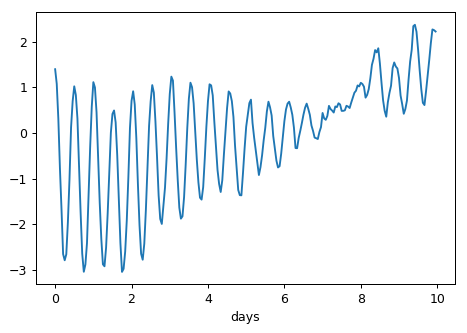

In [3]:
nt = 240

dt = 1/24 # 1 hour sample interval
tides = [24/12.42, 24/12]

t, h = datafaker(nt, dt=dt, freqs=tides, amp=1, 
                 color='r',
                 complex=False)
fig, ax = plt.subplots()
ax.plot(t, h)
ax.set_xlabel('days');

The starting point for the autospectrum is the discrete Fourier transform.  The squared amplitudes--discarding the phase--gives a raw periodogram. We are starting with a real series, so we don't need both the positive and the negative frequencies. We could use `np.fft.rfft` which only calculates the positive frequencies, but since we will be working with complex inputs later, we will instead use `np.fft.fft` for everything, and sacrifice some efficiency.

In [4]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw


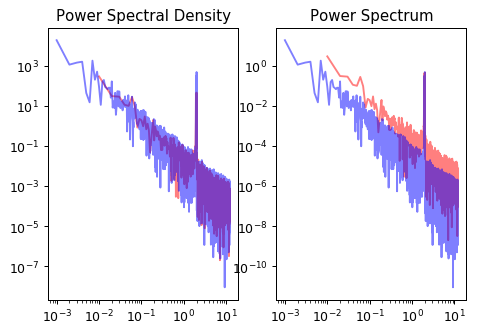

In [5]:
# Pick two data lengths as number of samples.  These will be used
# throughout the following examples.  They need to be quite large
# for the examples to work well.
n1 = 2400
n2 = 24000

dfkw = dict(dt=dt, freqs=tides, amp=1, color='r', complex=False)

t, h1 = datafaker(n1, **dfkw)
freqs1, ps1, psd1 = spectrum1(h1, dt=dt)

t, h2 = datafaker(n2, **dfkw)
freqs2, ps2, psd2 = spectrum1(h2, dt=dt)

fig, axs = plt.subplots(ncols=2, sharex=True)
axs[0].loglog(freqs1, psd1, 'r',
              freqs2, psd2, 'b', alpha=0.5)
axs[1].loglog(freqs1, ps1, 'r', 
              freqs2, ps2, 'b', alpha=0.5)
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectrum')
axs[1].axis('tight', which='x');

Given a time series of $N$ points, $h_j$, and the corresponding $N$ Fourier Transform coefficients, $H_k$, then Parseval's Theorem can be written as
$$\frac{1}{N}\sum_j |h_j|^2 = \frac{1}{N^2} \sum_k |H_k|^2.$$
This is why, in `spectrum1`, we divide each $|H_k|^2$ by $N^2$ to get the Power Spectrum (PS)---so that the value of the PS at each frequency will be the contribution of that frequency to the total *variance* in the time series.

Check this for our example; note that `spectrum1` is discarding the mean, consistent with the use of the `var` method of the time series.  It is also discarding the Nyquist, however, so we lose a tiny bit of the variance.


In [6]:
print('PS sum:   %.2f, %.2f' % (ps1.sum(), ps2.sum()))
print('Variance: %.2f, %.2f' % (h1.var(), h2.var()))
print('Differences: %g, %g' % (h1.var() - ps1.sum(),
                               h2.var() - ps2.sum()))

PS sum:   5.45, 29.10
Variance: 5.45, 29.10
Differences: 8.23172e-07, 2.45391e-08


Why does the *variance* increase between case 1 and case 2 in this example, where the sampling interval remains the same but the *length* of the record is increased by a factor of 10?  Does this depend on the character of the noise component?  Experiment to find out.

Next consider the Power Spectral *Density* (PSD), where in our minimal `spectrum1` function we have multiplied the PS values by the record length, $L = N \Delta t$.  Recall that the interval between Fourier frequencies is $\Delta f = 1/L$ in cycles per unit time, and we have $N$ of them in all---$N$ data points, and $N$ frequencies.  Therefore if we sum the PSD *times* $\Delta f$, which is the discrete analog of $\int_{-N/2}^{N/2-1} PSD\,df$, we get back the variance. In other words, and more generally, the *integral* of the PSD over a given frequency band is not sensitive to the record length, other things being equal.

Applied to the tidal peak, this means that as the record length is increased, the Fourier transform at the peak frequency (assuming it is on a Fourier frequency) stays the same, but the PSD increases; as $\Delta f$ gets smaller, the peak PSD has to increase to keep the integral---the contribution of that single sinusoid to the variance---constant. 

In [7]:
print('Tidal peak')

# Find a small band centered on the tidal constituents:
cond1 = (freqs1 < 24/11) & (freqs1 > 24/13.5) 
df1 = 1 / (len(h1) * dt)
psdint1 = psd1[cond1].sum() * df1

cond2 = (freqs2 < 24/11.9) & (freqs2 > 24/12.52) 
df2 = 1 / (len(h2) * dt)
psdint2 = psd2[cond2].sum() * df2

print('PSD integral:%.2f, %.2f' % (psdint1, psdint2))

print('PS tidal max: %.2g, %.2g' % (ps1[cond1].max(),
                                    ps2[cond2].max()) )
print('PSD tidal max: %.2g, %.2g' % (psd1[cond1].max(),
                                    psd2[cond2].max()) )

Tidal peak
PSD integral:0.98, 0.99
PS tidal max: 0.47, 0.5
PSD tidal max: 47, 5e+02


Notice that for the tidal peaks, the PS preserves the amplitude while the PSD preserves the integral, but not the amplitude.  For the background noise, their roles are reversed: the spectral level is preserved by the PSD, but not by the PS.

To get stable numbers in the calculations above requires sufficiently long time series, hence the choice of 2400 and 24000 hours.

Now, why do we get a PSD integral over the tide band of approximately 1, and PS max values of 0.5?  Recall that our fake tide is being generated with two sinusoids of unit amplitude.  The variance contributed by each is 0.5, hence the PS max value.  Integrating over the tidal band we have the sum of the two variances, hence 1.

The output of spectrum1 is very noisy; this is inherent in the raw periodogram.  We start with `nt` degrees of freedom in the original time series, and we are reducing it only by a factor of two in our `nt/2` frequencies.  Random noise input yields random sine and cosine coefficients in the FT, leading to a $\chi^2$ distribution for the squared amplitudes.  To reduce the noisiness, we need to smooth the spectrum, sacrificing resolution in frequency space.  This can be done by dividing the time series up into segments, calculating a spectrum for each segment, and averaging these spectra; this is sometimes called the "Welch method".  Alternatively, it can be done by directly smoothing the periodogram.  Let's start with the smoothing method, which is easier to implement.

In [8]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s
    

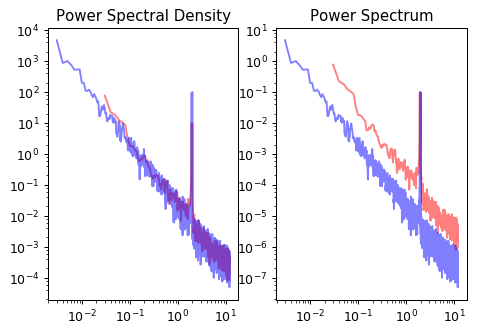

In [9]:
dfkw = dict(dt=dt, freqs=tides, amp=1, color='r', complex=False)

t, h1 = datafaker(n1, **dfkw)
freqs1, ps1, psd1 = spectrum2(h1, dt=dt)

t, h2 = datafaker(n2, **dfkw)
freqs2, ps2, psd2 = spectrum2(h2, dt=dt)

fig, axs = plt.subplots(ncols=2, sharex=True)
axs[0].loglog(freqs1, psd1, 'r',
              freqs2, psd2, 'b', alpha=0.5)
axs[1].loglog(freqs1, ps1, 'r', 
              freqs2, ps2, 'b', alpha=0.5)
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectrum')
axs[1].axis('tight', which='x');

The smoothing does what one expects--but there's more we need to do.  This time series with the red spectrum has a trend in it, and that is biasing the spectral estimates.  We need to detrend the series.  A typical way is by removing a simple linear fit.  Because the points are assumed to be evenly spaced, we don't need the actual array of sampling times.

In [10]:
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)
    

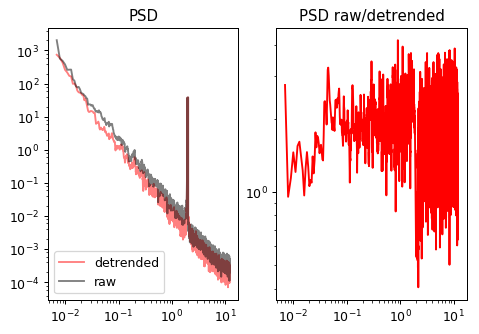

In [11]:
dfkw = dict(dt=dt, freqs=tides, amp=1, color='r', complex=False)
# smooth more heavily to make plot less noisy
ns = 13

t, h1 = datafaker(n1, **dfkw)
t, h2 = datafaker(n2, **dfkw)

freqs1, ps1, psd1 = spectrum3(h1, dt=dt, nsmooth=ns)
freqs2, ps2, psd2 = spectrum3(h2, dt=dt, nsmooth=ns)
freqs2a, ps2a, psd2a = spectrum2(h2, dt=dt, nsmooth=ns)

fig, axs = plt.subplots(ncols=2, sharex=True)

axs[0].loglog(freqs2, psd2, 'r', alpha=0.5, label='detrended') 
axs[0].loglog(freqs2, psd2a, 'k', alpha=0.5, label='raw')
axs[0].set_title('PSD')
axs[0].legend(loc='lower left')

axs[1].loglog(freqs2, psd2a/psd2, 'r')
axs[1].set_title('PSD raw/detrended')
axs[1].axis('tight', which='x');

The detrending has reduced the PSD at most frequencies all across the frequency range.

We still haven't done all we can to optimize our spectral estimate, however.  The detrended input is still not periodic, so a periodic continuation of it will have a discontinuity at each integer multiple of the record length.  To get rid of this, the standard technique is to multiply the signal by a smooth window after detrending.  This reduces the resolution in frequency space, but it also reduces leakage--the splattering of energy into a range of frequencies, when the original signal is not at a Fourier frequency.

In [12]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [13]:
dfkw = dict(dt=dt, freqs=tides, amp=1, color='r', complex=False)

t1, h1 = datafaker(n1, **dfkw)
#t2, h2 = datafaker(n2, **dfkw)

Before looking at how use of the window changes the spectral estimate, let's look at the time series before and after the detrending and windowing.

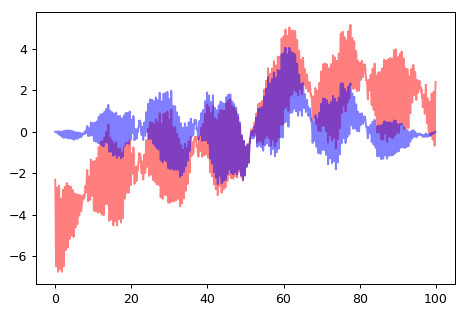

In [14]:
def win_dtr(h):
    n = len(h)
    h_detrended = detrend(h)    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    return h_win

fig, ax = plt.subplots()
ax.plot(t1, h1, 'r', t1, win_dtr(h1), 'b', alpha=0.5);

Now show the spectral estimates.

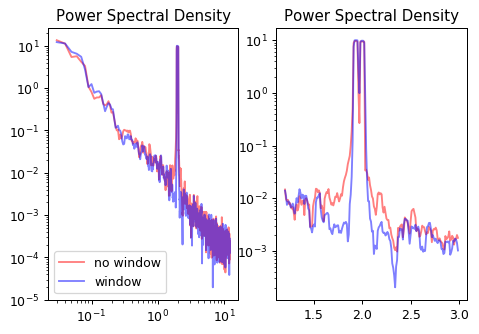

In [15]:
freqs1, ps1, psd1 = spectrum4(h1, dt=dt)
freqs1a, ps1a, psd1a = spectrum3(h1, dt=dt)

fig, axs = plt.subplots(ncols=2)
axs[0].loglog(freqs1, psd1a, 'r', alpha=0.5, label='no window')
axs[0].loglog(freqs1, psd1, 'b', alpha=0.5, label='window')
axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left')

i0, i1 = np.searchsorted(freqs1, [1.2, 3])
sl = slice(i0, i1)
axs[1].semilogy(freqs1[sl], psd1a[sl], 'r', 
              freqs1[sl], psd1[sl], 'b', alpha=0.5)
axs[1].axis('tight', which='x')
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectral Density');

The effect of the window in this case is quite subtle, and mostly visible in the region immediately adjacent to the tidal peak, to which we have zoomed in the right panel. From the left panel, we can see that the weighting we applied to the spectral estimate has effectively compensated for the loss of energy in the time series caused by the window; the general spectral level is the same for both curves.

## Confidence limits

Each raw periodogram value is the sum of squares of two random values, the cosine and sine coefficients for the corresponding Fourier frequency.  If the coefficients are unit normal random variables, then twice the periodogram value will have a $\chi_\nu^2$ distribution with $\nu = 2$ degrees of freedom. Band-averaging and/or segment averaging increases the DOF.  With a 5-point running mean, for example, $\nu = 10$.  Let $F_\nu(x)$ be the CDF of the $\chi_\nu^2$ distribution.  Then if $\hat{S}$ is the sample estimate of the PSD at a given frequency and $S$ is its true value, $\frac{\nu\hat{S}}{S}$ is $\chi_\nu^2$ distributed and the probability is $1-\alpha$ that
$$F_\nu(\frac{\alpha}{2}) < \frac{\nu\hat{S}}{S} < F_\nu(1-\frac{\alpha}{2}).$$
We can take the reciprocal and multiply through by $\nu\hat{S}$ to get the confidence limits for $S$:

$$ \frac{\nu\hat{S}}{F_\nu(1-\frac{\alpha}{2})} < S < \frac{\nu\hat{S}}{F_\nu(\frac{\alpha}{2})}$$

With a log scale for plotting $\hat{S}$ this makes the error bars the same length for any value of $\hat{S}$! So long as the DOF is the same for all frequencies, only a single error bar needs to be plotted, and it can be located anywhere on the plot. The $\chi_\nu^2$ distribution has a longer tail on the right than on the left.  On the log scale the asymmetry looks smaller, but the upper side of the confidence bar is still longer than the lower side.  Remember that with the log scale, the length of an interval is a multiplicative factor, not an additive one.  

You might be wondering why the factor of $\nu$ keeps appearing.  The answer is that the periodogram estimate is an average, but the $\chi_\nu^2$ distribution is defined for the *sum* of squares, not the *mean* of the squares.

Here is an example similar to the right panel above, again showing the leakage suppression from using the window (sometimes called a "taper"), and at the same time illustrating a simple error bar for 95% confidence limits.

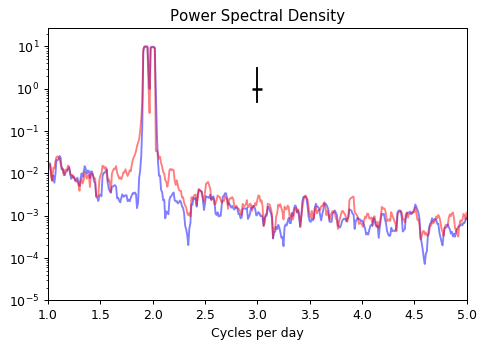

In [16]:
df = 10 # DOF for 5-point boxcar smoother

# location of confidence limit bar
conf_x = 3
conf_y0 = 1

conf = conf_y0 * df / ss.chi2.ppf([0.025, 0.975], df)

fig, ax = plt.subplots()
ax.semilogy(freqs1, psd1, 'b', alpha=0.5)
ax.semilogy(freqs1a, psd1a, 'r', alpha=0.5)

ax.plot([conf_x, conf_x], conf, color='k', lw=1.5)
ax.plot(conf_x, conf_y0, color='k', linestyle='none', 
        marker='_', ms=8, mew=2)

ax.set_xlim(1, 5)
ax.set_title('Power Spectral Density')
ax.set_xlabel('Cycles per day');

## Plotting: variance preserving

Using a log scale for the frequency axis is very helpful when most of the detailed information is expected to be in a relatively small fraction of the Fourier frequencies, at the low frequency end of the range.  When using a log scale for the frequency axis, using a log scale for the PSD axis as well has a big advantage: if PSD is proportional to the frequency to some power, then the plot will be a straight line, with the slope proportional to the power.  Hence, the popularity of the log-log plot for spectra.

A disadvantage of the log-log plot, however, is that it does not give a visual indication of how variance is distributed in frequency space; for that, we want the area under the curve between two frequencies to be proportional to the fraction of total variance between those frequencies.  This integral property is preserved when linear scales are used for frequency and PSD, but this scaling usually allocates too much space to very low contributions from a very large number of high Fourier frequencies; only a tiny slice on the left-hand side of the plot contains most of the signals of interest. An alternative is to use a "variance-preserving" plot with a log axis for frequency, and with PSD * frequency on the y-axis.

The area under the curve between two frequencies, as seen on the plot, is then 
$$\int_{f_1}^{f_2} S(f)\, f\, d(\log{f}) =  \int_{f_1}^{f_2} S(f)\, df$$
which is exactly what we want.
(Recall that $d(\log{f}) = \frac{df}{f}$.)

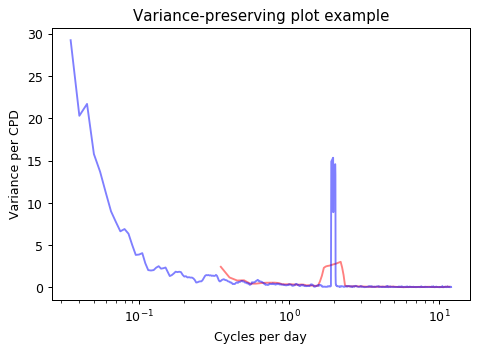

In [17]:
# Use higher amplitude background noise, and shorter time 
# series for this illustration.

dfkw = dict(dt=dt, freqs=tides, amp=5, color='r', complex=False)
# smooth more heavily to make plot less noisy
ns = 13
n1, n2 = 480, 4800
t, h1 = datafaker(n1, **dfkw)
t, h2 = datafaker(n2, **dfkw)

freqs1, ps1, psd1 = spectrum4(h1, dt=dt, nsmooth=ns)
freqs2, ps2, psd2 = spectrum4(h2, dt=dt, nsmooth=ns)

fig, ax = plt.subplots()

ax.semilogx(freqs1, psd1 * freqs1, 'r', alpha=0.5)
ax.semilogx(freqs2, psd2 * freqs2, 'b', alpha=0.5)

ax.set_title('Variance-preserving plot example')
ax.set_xlabel('Cycles per day')
ax.set_ylabel('Variance per CPD');


## Rotary spectra

So far, we have been showing spectral calculations for a scalar time series such as SSH.  A 2-D vector time series such as a current meter record can be represented using the complex plane: with east and north velocity components $u$ and $v$, define $u_c = u + iv$.  Then the Fourier transform maps $n$ complex numbers in the time domain into $n$ complex numbers in the frequency domain.  For each Fourier frequency magnitude, the positive and negative frequency amplitudes correspond to rotation of the vector in the positive (CCW) and negative (CW) direction with time. 

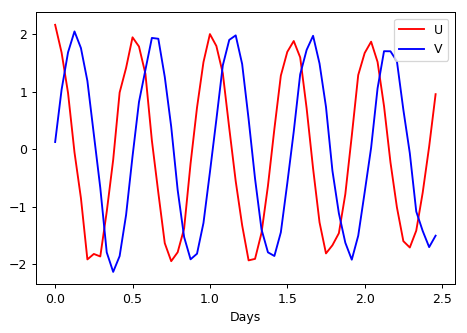

In [18]:
nt = 60

dt = 1/24 # 1 hour sample interval
tides = [24/12.42, 24/12]

t, uc = datafaker(nt, dt=dt, freqs=tides, amp=0.1, 
                 color='w',
                 complex=True)
fig, ax = plt.subplots()
ax.plot(t, uc.real, 'r', label='U')
ax.plot(t, uc.imag, 'b', label='V')
ax.legend(loc='upper right')
ax.set_xlabel('Days');

Notice the progression from eastward to northward to westward to southward: the CCW rotation of the velocity vector, which is a positive rotation in the mathematical sense.

Now we will add in a diurnal component rotating CW (negative math direction) and double the length of the time series.  We also add more background noise.

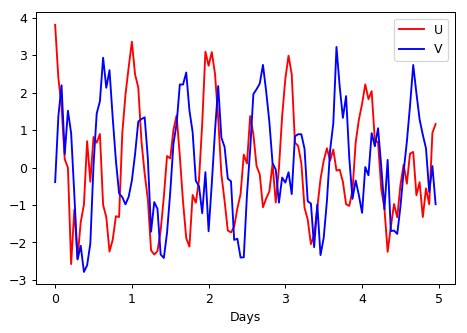

In [19]:
nt = 120

dt = 1/24 # 1 hour sample interval
tides = [24/12.42, 24/12, -1]

t, uc = datafaker(nt, dt=dt, freqs=tides, amp=0.5, 
                 color='w',
                 complex=True)
fig, ax = plt.subplots()
ax.plot(t, uc.real, 'r', label='U')
ax.plot(t, uc.imag, 'b', label='V')
ax.legend(loc='upper right')
ax.set_xlabel('Days');

Shortcut: I'm going to use an all-in-one spectrum estimation function from my pycurrents package.

In [20]:
s = spectra.spectrum(uc, nfft=None, dt=1/24, 
                     window='quadratic',
                     smooth=3)

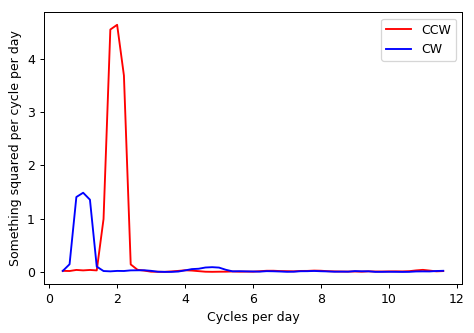

In [21]:
fig, ax = plt.subplots()
ax.plot(s.ccwfreqs, s.ccwpsd, 'r', label='CCW')
ax.plot(s.cwfreqs, s.cwpsd, 'b', label='CW')
ax.legend(loc='upper right')
ax.set_xlabel('Cycles per day')
ax.set_ylabel('Something squared per cycle per day');

As expected based on the way the fake time series was constructed, we find the semidiurnal energy in the CCW component, and the diurnal energy in the CW component.